# Regressor (House selling price prediction)
In this post, we will be covering some basics of data exploration and building a model with Keras in order to help us on predicting the selling price of a  house in the Boston (MA) area. As an application of this model in the real world, you can think about being a real state agent looking for a tool to help you on your day-to-day duties, which for me, at least, sounds pretty good when compared to just gut-estimation.

For this exercise, we will be using the Plotly library instead of the good ol' fashioned matplotlib, due to having more interactive plots, which for sure help in understanding the data. We will also use the Scikit-Learn and Keras for building the models, Pandas library to manipulate our data and the SHAP library to generate explanations for our trained model.


In [1]:
from sklearn.datasets import load_boston
import pandas as pd

boston_dataset = load_boston()

df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
df['MEDV'] = boston_dataset.target

df.head(n=10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


## Dataset
In this example, we wil be using the sklearn.datasets module, which contains the Boston dataset. You could also use the keras.datasets module, but this one does not contain the labels of the features, so we decided to use scikits one. Let's also convert it to a Pandas DataFrame and print it's head.

The features can be summarized as follows:
- CRIM: This is the per capita crime rate by town
- ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
- INDUS: This is the proportion of non-retail business acres per town.
- CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
- NOX: This is the nitric oxides concentration (parts per 10 million)
- RM: This is the average number of rooms per dwelling
- AGE: This is the proportion of owner-occupied units built prior to 1940
- DIS: This is the weighted distances to five Boston employment centers
- RAD: This is the index of accessibility to radial highways
- TAX: This is the full-value property-tax rate per 10,000 dollars
- PTRATIO: This is the pupil-teacher ratio by town
- B: This is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people of African American descent by town
- LSTAT: This is the percentage lower status of the population
- MEDV: This is the median value of owner-occupied homes in 1k dollars

# Exploratory Data Analysis
Making yourself comfortable and familiar with your dataset is a fundamental step to help you comprehend your data and draw better conclusions and explanations from your results.

Initially, let's plot a few box plots, which will help us to better visualize anomalies and/or outliers in data distribution. If you are confused about what is a box plot and how it can help us to better visualize the distribution of our data, here is a brief description from Ross (1977):

In descriptive statistics, a box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points.


In [2]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

total_items = len(df.columns)
items_per_row = 3
total_rows = math.ceil(total_items / items_per_row)

fig = make_subplots(rows=total_rows, cols=items_per_row)

cur_row = 1
cur_col = 1

for index, column in enumerate(df.columns):
    fig.add_trace(go.Box(y=df[column], name=column), row=cur_row, col=cur_col)
    
    if cur_col % items_per_row == 0:
        cur_col = 1
        cur_row = cur_row + 1
    else:
        cur_col = cur_col + 1
    

fig.update_layout(height=1000, width=550,  showlegend=False)
fig.show()

These results do corroborate our initial assumptions about having outliers in some columns. Let's also plot some scatter plots for each feature and the target variable, as well as their intercept lines:


In [3]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import numpy as np

total_items = len(df.columns)
items_per_row = 3
total_rows = math.ceil(total_items / items_per_row)

fig = make_subplots(rows=total_rows, cols=items_per_row, subplot_titles=df.columns)

cur_row = 1
cur_col = 1

for index, column in enumerate(df.columns):
    fig.add_trace(go.Scattergl(x=df[column], 
                            y=df['MEDV'], 
                            mode="markers", 
                            marker=dict(size=3)), 
                  row=cur_row, 
                  col=cur_col)
    
    intercept = np.poly1d(np.polyfit(df[column], df['MEDV'], 1))(np.unique(df[column]))
    
    fig.add_trace(go.Scatter(x=np.unique(df[column]), 
                             y=intercept, 
                             line=dict(color='red', width=1)), 
                  row=cur_row, 
                  col=cur_col)
    
    if cur_col % items_per_row == 0:
        cur_col = 1
        cur_row = cur_row + 1
    else:
        cur_col = cur_col + 1
    

fig.update_layout(height=1000, width=550, showlegend=False)
fig.show()

From this initial data exploration, we can have two major conclusions:

* There is a strong linear correlation between the RM (average number of rooms per dwelling) and LSTAT (% lower status of the population) with the target variable, being the RM a positive and the LSTAT a negative correlation.
* There are some records containing outliers, which we could preprocess in order to input our model with more normalized data.

# Data Preprocessing
Before we proceed into any data preprocessing, it's important to split our data into training and test sets. We should not apply any kind of preprocessing into our data without taking into account that we should not leak information from our test set. For this step, we can use the train_test_split method from scikit-learn. In this case, we will use a split of 70% of the data for training and 30% for testing. We also set a random_state seed, in order to allow reprocibility.

In [4]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'MEDV']
y = df.loc[:, df.columns == 'MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In order to provide a standardized input to our neural network, we need the perform the normalization of our dataset. This can be seen as an step to reduce the differences in scale that may arise from the existent features. We perform this normalization by subtracting the mean from our data and dividing it by the standard deviation. One more time, this normalization should only be performed by using the mean and standard deviation from the training set, in order to avoid any information leak from the test set.


In [5]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Building the Model
Due to the small amount of presented data in this dataset, we must be careful to not create an overly complex model, which could lead to overfitting our data. For this, we are going to adopt an architecture based on two Dense layers, the first with 128 and the second with 64 neurons, both using a ReLU activation function. A dense layer with a linear activation will be used as output layer.

In order to allow us to know if our model is properly learning, we will use a mean squared error loss function and to report the performance of it we will adopt the mean average error metric.

By using the summary method from Keras, we can see that we have a total of 10,113 parameters, which is acceptable for us.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

model.add(Dense(128, input_shape=(13, ), activation='relu', name='dense_1'))
model.add(Dense(64, activation='relu', name='dense_2'))
model.add(Dense(1, activation='linear', name='dense_output'))

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_output (Dense)         (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


# Training the Model
This step is pretty straightforward: fit our model with both our features and their labels, for a total amount of 100 epochs, separating 10% of the samples (39 records) as validation set.

In [7]:
epochs=150
validation_split = 0.10

history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split)

28ms/step - loss: 570.4085 - mae: 21.9904 - val_loss: 587.9753 - val_mae: 22.5044
Epoch 2/150
10/10 [==============================] - 0s 5ms/step - loss: 509.5562 - mae: 20.5684 - val_loss: 521.8078 - val_mae: 21.0584
Epoch 3/150
10/10 [==============================] - 0s 5ms/step - loss: 439.2816 - mae: 18.7820 - val_loss: 434.6642 - val_mae: 19.0193
Epoch 4/150
10/10 [==============================] - 0s 4ms/step - loss: 348.0918 - mae: 16.3914 - val_loss: 325.1910 - val_mae: 16.1886
Epoch 5/150
10/10 [==============================] - 0s 4ms/step - loss: 240.8738 - mae: 13.3302 - val_loss: 205.8932 - val_mae: 12.5025
Epoch 6/150
10/10 [==============================] - 0s 4ms/step - loss: 139.6068 - mae: 9.8520 - val_loss: 105.1540 - val_mae: 8.4348
Epoch 7/150
10/10 [==============================] - 0s 4ms/step - loss: 74.4356 - mae: 6.9398 - val_loss: 52.2117 - val_mae: 5.6025
Epoch 8/150
10/10 [==============================] - 0s 4ms/step - loss: 54.5310 - mae: 5.7417 - val_l


By plotting both loss and mean average error, we can see that our model was capable of learning patterns in our data without overfitting taking place (as shown by the validation set curves):


In [8]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['loss'], name='Train'))
fig.add_trace(go.Scattergl(y=history.history['val_loss'], name='Valid'))

fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [9]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['mae'], name='Train'))
fig.add_trace(go.Scattergl(y=history.history['val_mae'], name='Valid'))

fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()

# Evaluating the Model

Deep Learning: Neural Networks

In [10]:
mse_nn, mae_nn = model.evaluate(X_test, y_test, verbose=1)
print('Mean squared error on test data: ', mse_nn)
print('Mean absolute error on test data: ', mae_nn)

5/5 [==============================] - 0s 953us/step - loss: 17.7152 - mae: 2.6850
Mean squared error on test data:  17.715171813964844
Mean absolute error on test data:  2.6849920749664307


Machine Learning: Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print('Mean squared error on test data: ', mse_lr)
print('Mean absolute error on test data: ', mae_lr)

Mean squared error on test data:  28.40585481050824
Mean absolute error on test data:  3.6913626771162575


Machine Learning: Decision Tree

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_tree)
mae_dt = mean_absolute_error(y_test, y_pred_tree)

print('Mean squared error on test data: ', mse_dt)
print('Mean absolute error on test data: ', mae_dt)

Mean squared error on test data:  17.86559210526316
Mean absolute error on test data:  2.8572368421052636


# Opening the Black Box (a.k.a. Explaining our Model)
Sometimes just a good result is enough for most of the people, but there are scenarios where we need to explain what are the major components used by our model to perform its prediction. For this task, we can rely on the SHAP library, which easily allows us to create a summary of our features and its impact on the model output. I won't dive deep into the details of SHAP, but if you are intered on it, you can check their github page or even give a look at its paper].


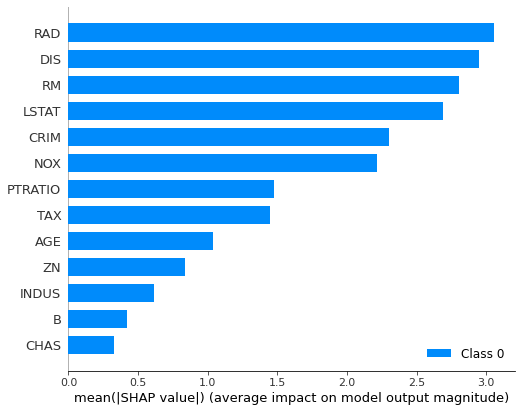

In [13]:
!pip install shap
import shap
shap.initjs()

explainer = shap.GradientExplainer(model, X_train[:150].values)
shap_values = explainer.shap_values(X_test[:150].values)
shap.summary_plot(shap_values, X_test, plot_type='bar')

From this simple plot, we can see that the major features that have an impact on the model output are:

- LSTAT: % lower status of the population
- RM: average number of rooms per dwelling
- RAD: index of accessibility to radial highways
- DIS: weighted distances to five Boston employment centres
- NOX: nitric oxides concentration (parts per 10 million) - this may more likely be correlated with greenness of the area
- CRIM: per capita crime rate by town

From this plot, we can clearly corroborate our initial EDA analysis in which we point out the LSTAT and RM features as having a high correlation with the model outcome.

# Conclusions

In this post, we have showed that by using a Neural Network, we can easily outperform traditional Machine Learning methods by a good margin. We also show that, even when using a more complex model, when compared to other techniques, we can still explain the outcomes of our model by using the SHAP library.

Furthermore, we need to have in mind that the explored dataset can be somehow outdated, and some feature engineering (such as correcting prices for inflaction) could be performed in order to better reflect current scenarios.

The Jupyter notebook for this post can be found here.

References
Boston Dataset: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

Plotly: https://plot.ly/python/

ScikitLearn: https://scikit-learn.org/stable/

Keras: https://keras.io/

Pandas: https://pandas.pydata.org/

SHAP Project Page: https://github.com/slundberg/shap

SHAP Paper: https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

Introduction to probability and statistics for engineers and scientists. https://www.amazon.com.br/dp/B007ZBZN9U/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1